# Latin-English Translation Fine-Tuning Pipeline

**Complete end-to-end notebook for fine-tuning GPT-4o-mini on Latin-English translation**

---

## Project Summary

| Item | Value |
|------|-------|
| **Dataset** | grosenthal/latin_english_translation (HuggingFace) |
| **Total Samples** | 101,371 |
| **Model** | GPT-4o-mini (`gpt-4o-mini-2024-07-18`) |
| **Training Samples** | 50,000 |
| **Validation Samples** | 5,000 |
| **Epochs** | 2 |
| **Estimated Cost** | ~$36.21 |

---

## Pipeline Steps

1. **Setup** - Install dependencies
2. **Step 1** - Download dataset from HuggingFace
3. **Step 2** - Analyze token distribution
4. **Step 3** - Prepare JSONL files for fine-tuning
5. **Step 4** - Upload to OpenAI & Fine-tune (manual)
6. **Step 5** - Evaluate fine-tuned model with BLEU scores

---

## Setup - Install Dependencies

In [ ]:
# Install required packages
!pip install datasets tiktoken pandas tqdm openai nltk matplotlib --quiet
# Download NLTK data for BLEU calculation
import nltk
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
print("All dependencies installed!")

All dependencies installed!


In [ ]:
# Common imports used throughout
import os
import json
import random
import pandas as pd
import tiktoken
from datetime import datetime
from collections import defaultdict
from tqdm import tqdm

# Set working directory
WORKING_DIR = os.getcwd()
print(f"Working directory: {WORKING_DIR}")

# Create necessary directories
os.makedirs(os.path.join(WORKING_DIR, "data"), exist_ok=True)
os.makedirs(os.path.join(WORKING_DIR, "analysis"), exist_ok=True)
os.makedirs(os.path.join(WORKING_DIR, "output"), exist_ok=True)
os.makedirs(os.path.join(WORKING_DIR, "evaluation"), exist_ok=True)

print("Directories created!")

Working directory: /content
Directories created!


---

# STEP 1: Download Dataset

Download the Latin-English translation dataset from HuggingFace and save as CSV.

**Source:** `grosenthal/latin_english_translation`

**Output:** `data/latin_english_dataset.csv`

In [ ]:
from datasets import load_dataset

print("=" * 60)
print("STEP 1: Download Latin-English Translation Dataset")
print("=" * 60)

# Download dataset from Hugging Face
print("\nDownloading dataset from HuggingFace...")
print("Dataset: grosenthal/latin_english_translation")

dataset = load_dataset("grosenthal/latin_english_translation")

print("\nDataset loaded successfully!")
print(f"Splits available: {list(dataset.keys())}")

STEP 1: Download Latin-English Translation Dataset

Dataset: grosenthal/latin_english_translation


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-2a6c50c220f24d(…):   0%|          | 0.00/24.6M [00:00<?, ?B/s]

data/test-00000-of-00001-1de1c07e0353502(…):   0%|          | 0.00/257k [00:00<?, ?B/s]

data/valid-00000-of-00001-9bf7a5c42e9f38(…):   0%|          | 0.00/249k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/99343 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1014 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/1014 [00:00<?, ? examples/s]


Dataset loaded successfully!
Splits available: ['train', 'test', 'valid']


In [ ]:
# Combine all splits into single dataframe
all_data = []

for split_name in dataset.keys():
    split_data = dataset[split_name]
    print(f"{split_name}: {len(split_data)} samples")

    for idx, item in enumerate(split_data):
        all_data.append({
            'sno': len(all_data) + 1,
            'la_text': item['la'],
            'eng_text': item['en'],
            'split': split_name,
            'source': item.get('file', 'unknown')
        })

# Create DataFrame
df = pd.DataFrame(all_data)

# Save to CSV
output_path = os.path.join(WORKING_DIR, "data", "latin_english_dataset.csv")
df.to_csv(output_path, index=False, encoding='utf-8')

print(f"\n{'=' * 60}")
print("DOWNLOAD COMPLETE")
print(f"{'=' * 60}")
print(f"\nOutput file: {output_path}")
print(f"Total samples: {len(df):,}")
print(f"\nSamples by split:")
print(df['split'].value_counts().to_string())

train: 99343 samples
test: 1014 samples
valid: 1014 samples

DOWNLOAD COMPLETE

Output file: /content/data/latin_english_dataset.csv
Total samples: 101,371

Samples by split:
split
train    99343
test      1014
valid     1014


In [ ]:
# Preview sample data
print("Sample data preview:")
print("-" * 60)
sample = df.iloc[0]
print(f"SNO: {sample['sno']}")
print(f"Latin: {sample['la_text'][:100]}...")
print(f"English: {sample['eng_text'][:100]}...")
print(f"Split: {sample['split']}")
print(f"Source: {sample['source']}")

Sample data preview:
------------------------------------------------------------
SNO: 1
Latin: post haec ambulabat Iesus in Galilaeam non enim volebat in Iudaeam ambulare quia quaerebant eum Iuda...
English: After these things, Jesus walked in Galilee: for he would not walk in Judea, because the Jews sought...
Split: train
Source: final_alignments\Vulgate_Bible.json


---

# STEP 2: Analyze Token Distribution

Analyze the dataset to understand token counts, costs, and distributions.

**Output:**
- `analysis/token_stats.json`
- `analysis/token_distribution.png`

In [ ]:
# Constants for prompt structure
SYSTEM_PROMPT = "You are an expert Latin to English translator. Translate the following Latin text to fluent, accurate English."
USER_PROMPT_PREFIX = "Translate: "

# GPT-4o-mini pricing (per 1M tokens)
TRAINING_COST_PER_M = 3.00  # $3 per 1M tokens
EPOCHS = 2

def count_tokens(text: str, encoder) -> int:
    """Count tokens in a text string."""
    return len(encoder.encode(text))

def calculate_sample_tokens(la_text: str, eng_text: str, encoder) -> dict:
    """Calculate tokens for a complete training example."""
    system_tokens = count_tokens(SYSTEM_PROMPT, encoder)
    user_tokens = count_tokens(USER_PROMPT_PREFIX + la_text, encoder)
    assistant_tokens = count_tokens(eng_text, encoder)
    overhead = 12  # 3 messages x 4 tokens each for chat format

    total = system_tokens + user_tokens + assistant_tokens + overhead

    return {
        'system': system_tokens,
        'user': user_tokens,
        'assistant': assistant_tokens,
        'overhead': overhead,
        'total': total,
        'la_only': count_tokens(la_text, encoder),
        'eng_only': count_tokens(eng_text, encoder)
    }

def get_source_category(source: str) -> str:
    """Categorize source as Loeb or Vulgate."""
    if 'Vulgate' in source or 'Bible' in source:
        return 'Vulgate'
    return 'Loeb'

def assign_length_bucket(total_tokens: int) -> str:
    """Assign sample to length bucket."""
    if total_tokens < 100:
        return 'Short'
    elif total_tokens < 300:
        return 'Medium'
    elif total_tokens < 500:
        return 'Long'
    else:
        return 'VeryLong'

print("Helper functions defined!")

Helper functions defined!


In [ ]:
print("=" * 70)
print("STEP 2: Token Analysis")
print("=" * 70)

# Load dataset
data_path = os.path.join(WORKING_DIR, "data", "latin_english_dataset.csv")
df = pd.read_csv(data_path)
print(f"\nLoaded {len(df):,} samples")

# Initialize tiktoken encoder
print("\nInitializing tiktoken encoder (cl100k_base for GPT-4o-mini)...")
encoder = tiktoken.get_encoding("cl100k_base")

# Calculate tokens for each sample
print("\nCalculating tokens for each sample...")
token_data = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):
    tokens = calculate_sample_tokens(row['la_text'], row['eng_text'], encoder)
    tokens['sno'] = row['sno']
    tokens['split'] = row['split']
    tokens['source'] = row['source']
    tokens['source_category'] = get_source_category(row['source'])
    tokens['length_bucket'] = assign_length_bucket(tokens['total'])
    token_data.append(tokens)

token_df = pd.DataFrame(token_data)
print("\nToken calculation complete!")

STEP 2: Token Analysis

Loaded 101,371 samples

Initializing tiktoken encoder (cl100k_base for GPT-4o-mini)...

Calculating tokens for each sample...


Processing: 100%|██████████| 101371/101371 [00:29<00:00, 3474.63it/s]



Token calculation complete!


In [ ]:
# Calculate statistics
print("\n" + "=" * 70)
print("TOKEN STATISTICS")
print("=" * 70)

stats = {
    'total_samples': len(token_df),
    'total_tokens': int(token_df['total'].sum()),
    'min_tokens': int(token_df['total'].min()),
    'max_tokens': int(token_df['total'].max()),
    'mean_tokens': float(token_df['total'].mean()),
    'median_tokens': float(token_df['total'].median()),
    'std_tokens': float(token_df['total'].std()),
    'percentiles': {
        '25th': float(token_df['total'].quantile(0.25)),
        '50th': float(token_df['total'].quantile(0.50)),
        '75th': float(token_df['total'].quantile(0.75)),
        '90th': float(token_df['total'].quantile(0.90)),
        '95th': float(token_df['total'].quantile(0.95)),
        '99th': float(token_df['total'].quantile(0.99))
    }
}

print(f"\nTotal samples: {stats['total_samples']:,}")
print(f"Total tokens: {stats['total_tokens']:,}")
print(f"\nTokens per sample:")
print(f"  Min: {stats['min_tokens']}")
print(f"  Max: {stats['max_tokens']}")
print(f"  Mean: {stats['mean_tokens']:.1f}")
print(f"  Median: {stats['median_tokens']:.1f}")
print(f"  Std Dev: {stats['std_tokens']:.1f}")
print(f"\nPercentiles:")
for p, v in stats['percentiles'].items():
    print(f"  {p}: {v:.0f} tokens")


TOKEN STATISTICS

Total samples: 101,371
Total tokens: 12,228,717

Tokens per sample:
  Min: 36
  Max: 905
  Mean: 120.6
  Median: 107.0
  Std Dev: 55.7

Percentiles:
  25th: 83 tokens
  50th: 107 tokens
  75th: 142 tokens
  90th: 190 tokens
  95th: 230 tokens
  99th: 320 tokens


In [ ]:
# Analysis by source and length bucket
print("\n" + "-" * 70)
print("TOKENS BY SOURCE CATEGORY")
print("-" * 70)
source_stats = token_df.groupby('source_category')['total'].agg(['count', 'sum', 'mean']).round(1)
print(source_stats.to_string())

print("\n" + "-" * 70)
print("SAMPLES BY LENGTH BUCKET")
print("-" * 70)
bucket_stats = token_df.groupby('length_bucket')['total'].agg(['count', 'mean']).round(1)
bucket_stats['percentage'] = (bucket_stats['count'] / len(token_df) * 100).round(1)
print(bucket_stats.to_string())


----------------------------------------------------------------------
TOKENS BY SOURCE CATEGORY
----------------------------------------------------------------------
                 count      sum   mean
source_category                       
Loeb             68335  8972304  131.3
Vulgate          33036  3256413   98.6

----------------------------------------------------------------------
SAMPLES BY LENGTH BUCKET
----------------------------------------------------------------------
               count   mean  percentage
length_bucket                          
Long            1424  349.5         1.4
Medium         55678  147.4        54.9
Short          44214   79.1        43.6
VeryLong          55  569.7         0.1


In [ ]:
# Cost estimation
print("\n" + "=" * 70)
print("COST ESTIMATION (GPT-4o-mini, 2 epochs)")
print("=" * 70)

sample_sizes = [5000, 10000, 20000, 50000, len(df)]
cost_estimates = []

for n in sample_sizes:
    subset = token_df.head(n)
    total_tokens = subset['total'].sum()
    training_tokens = total_tokens * EPOCHS
    cost = (training_tokens / 1_000_000) * TRAINING_COST_PER_M

    cost_estimates.append({
        'samples': n if n < len(df) else 'all',
        'tokens': int(total_tokens),
        'training_tokens': int(training_tokens),
        'estimated_cost': round(cost, 2)
    })

    label = f"{n:,}" if n < len(df) else f"all ({len(df):,})"
    print(f"\n{label} samples:")
    print(f"  Total tokens: {total_tokens:,}")
    print(f"  Training tokens (x{EPOCHS} epochs): {training_tokens:,}")
    print(f"  Estimated cost: ${cost:.2f}")

stats['cost_estimates'] = cost_estimates


COST ESTIMATION (GPT-4o-mini, 2 epochs)

5,000 samples:
  Total tokens: 607,627
  Training tokens (x2 epochs): 1,215,254
  Estimated cost: $3.65

10,000 samples:
  Total tokens: 1,208,184
  Training tokens (x2 epochs): 2,416,368
  Estimated cost: $7.25

20,000 samples:
  Total tokens: 2,409,544
  Training tokens (x2 epochs): 4,819,088
  Estimated cost: $14.46

50,000 samples:
  Total tokens: 6,024,507
  Training tokens (x2 epochs): 12,049,014
  Estimated cost: $36.15

all (101,371) samples:
  Total tokens: 12,228,717
  Training tokens (x2 epochs): 24,457,434
  Estimated cost: $73.37


In [ ]:
# Save statistics
stats_path = os.path.join(WORKING_DIR, "analysis", "token_stats.json")
with open(stats_path, 'w', encoding='utf-8') as f:
    json.dump(stats, f, indent=2)
print(f"\nStatistics saved to: {stats_path}")


Statistics saved to: /content/analysis/token_stats.json


Visualization saved to: /content/analysis/token_distribution.png


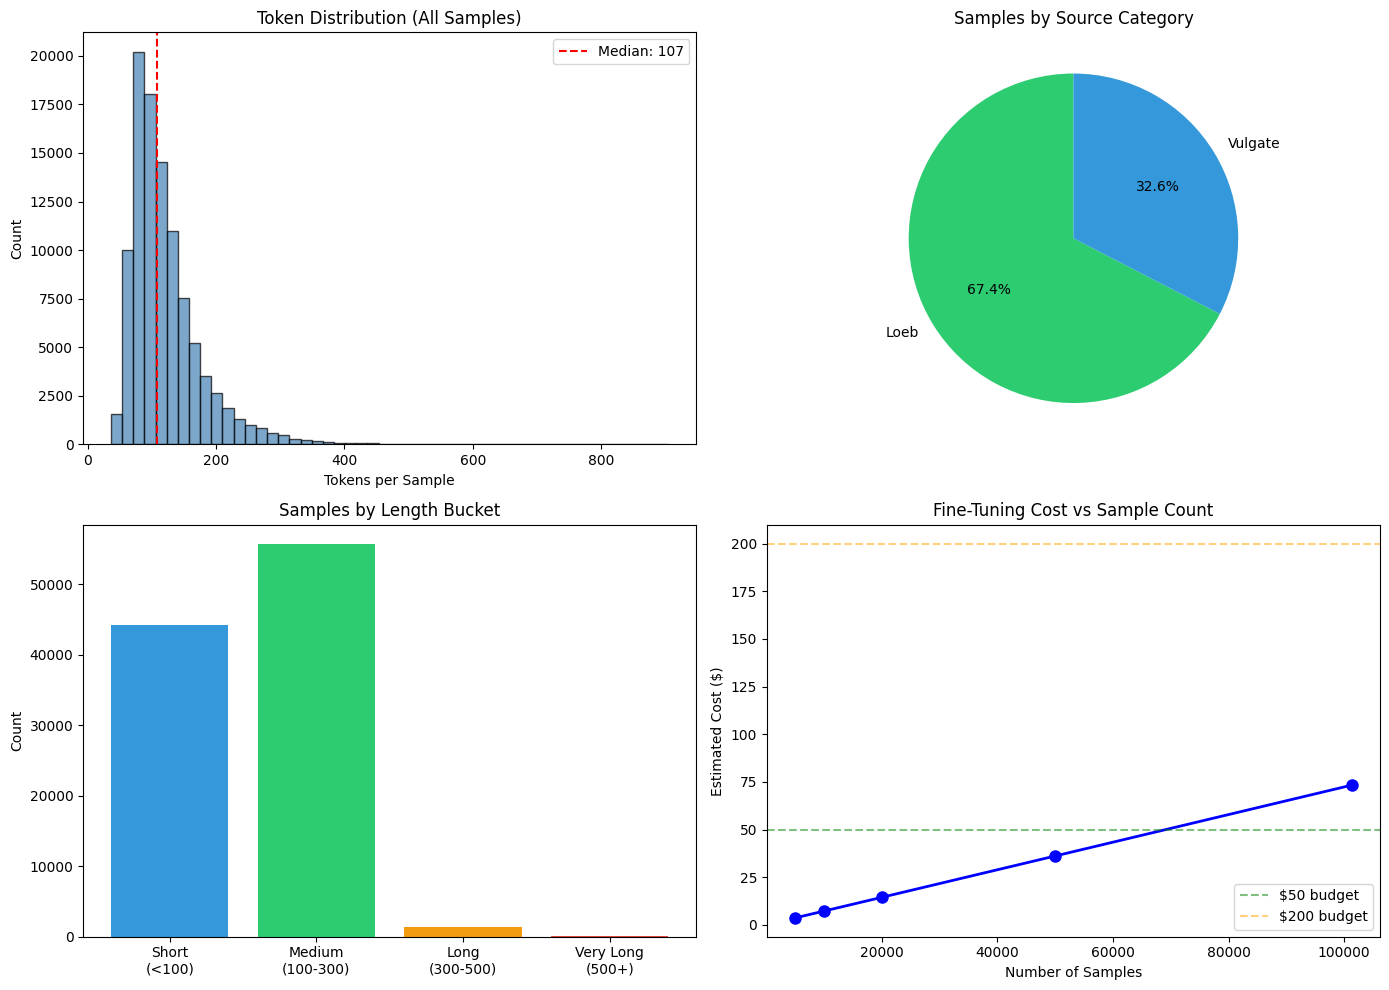

In [ ]:
# Generate visualization
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Token distribution histogram
ax1 = axes[0, 0]
ax1.hist(token_df['total'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.set_xlabel('Tokens per Sample')
ax1.set_ylabel('Count')
ax1.set_title('Token Distribution (All Samples)')
ax1.axvline(stats['median_tokens'], color='red', linestyle='--', label=f"Median: {stats['median_tokens']:.0f}")
ax1.legend()

# 2. By source category
ax2 = axes[0, 1]
source_counts = token_df['source_category'].value_counts()
ax2.pie(source_counts, labels=source_counts.index, autopct='%1.1f%%', startangle=90, colors=['#2ecc71', '#3498db'])
ax2.set_title('Samples by Source Category')

# 3. By length bucket
ax3 = axes[1, 0]
bucket_order = ['Short', 'Medium', 'Long', 'VeryLong']
bucket_counts = token_df['length_bucket'].value_counts().reindex(bucket_order, fill_value=0)
colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
ax3.bar(range(len(bucket_counts)), bucket_counts.values, color=colors)
ax3.set_xticks(range(len(bucket_counts)))
ax3.set_xticklabels(['Short\n(<100)', 'Medium\n(100-300)', 'Long\n(300-500)', 'Very Long\n(500+)'])
ax3.set_ylabel('Count')
ax3.set_title('Samples by Length Bucket')

# 4. Cost vs samples
ax4 = axes[1, 1]
samples = [c['samples'] if isinstance(c['samples'], int) else len(df) for c in cost_estimates]
costs = [c['estimated_cost'] for c in cost_estimates]
ax4.plot(samples, costs, 'bo-', markersize=8, linewidth=2)
ax4.set_xlabel('Number of Samples')
ax4.set_ylabel('Estimated Cost ($)')
ax4.set_title('Fine-Tuning Cost vs Sample Count')
ax4.axhline(50, color='green', linestyle='--', alpha=0.5, label='$50 budget')
ax4.axhline(200, color='orange', linestyle='--', alpha=0.5, label='$200 budget')
ax4.legend()

plt.tight_layout()
viz_path = os.path.join(WORKING_DIR, "analysis", "token_distribution.png")
plt.savefig(viz_path, dpi=150)
print(f"Visualization saved to: {viz_path}")
plt.show()

---

# STEP 3: Prepare JSONL for Fine-Tuning

Create stratified training and validation JSONL files.

**Configuration:**
- Training samples: 50,000
- Validation samples: 5,000
- Stratified by length bucket and source

**Output:**
- `output/train.jsonl`
- `output/validation.jsonl`
- `output/preparation_report.json`

In [ ]:
# Configuration
TRAIN_SAMPLES = 50000
VAL_SAMPLES = 5000
RANDOM_SEED = 20251204

print(f"Configuration:")
print(f"  Training samples: {TRAIN_SAMPLES:,}")
print(f"  Validation samples: {VAL_SAMPLES:,}")
print(f"  Random seed: {RANDOM_SEED}")

Configuration:
  Training samples: 50,000
  Validation samples: 5,000
  Random seed: 20251204


In [ ]:
def create_jsonl_entry(la_text: str, eng_text: str) -> dict:
    """Create a single JSONL entry for OpenAI fine-tuning."""
    return {
        "messages": [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": f"{USER_PROMPT_PREFIX}{la_text}"},
            {"role": "assistant", "content": eng_text}
        ]
    }

def stratified_sample(df: pd.DataFrame, n_samples: int, encoder) -> pd.DataFrame:
    """
    Perform stratified sampling across length buckets and source categories.
    """
    random.seed(RANDOM_SEED)

    # Calculate tokens and assign categories
    df = df.copy()

    print("Calculating tokens for stratification...")
    df['tokens'] = df.apply(
        lambda row: calculate_sample_tokens(row['la_text'], row['eng_text'], encoder)['total'],
        axis=1
    )
    df['source_category'] = df['source'].apply(get_source_category)
    df['length_bucket'] = df['tokens'].apply(assign_length_bucket)

    # Create combined strata
    df['stratum'] = df['length_bucket'] + '_' + df['source_category']

    # Calculate samples per stratum (proportional)
    strata_counts = df['stratum'].value_counts()
    strata_proportions = strata_counts / len(df)

    selected_indices = []

    for stratum, proportion in strata_proportions.items():
        stratum_df = df[df['stratum'] == stratum]
        n_from_stratum = max(1, int(n_samples * proportion))
        n_from_stratum = min(n_from_stratum, len(stratum_df))

        selected = stratum_df.sample(n=n_from_stratum, random_state=RANDOM_SEED)
        selected_indices.extend(selected.index.tolist())

    # Adjust to exact target
    remaining_needed = n_samples - len(selected_indices)
    if remaining_needed > 0:
        remaining_df = df[~df.index.isin(selected_indices)]
        if len(remaining_df) > 0:
            additional = remaining_df.sample(n=min(remaining_needed, len(remaining_df)), random_state=RANDOM_SEED)
            selected_indices.extend(additional.index.tolist())

    if len(selected_indices) > n_samples:
        random.shuffle(selected_indices)
        selected_indices = selected_indices[:n_samples]

    return df.loc[selected_indices]

print("Sampling functions defined!")

Sampling functions defined!


In [ ]:
print("=" * 70)
print("STEP 3: Prepare JSONL Files")
print("=" * 70)

# Load dataset
df = pd.read_csv(os.path.join(WORKING_DIR, "data", "latin_english_dataset.csv"))
print(f"\nLoaded {len(df):,} samples")

# Use only training split
train_df = df[df['split'] == 'train'].copy()
print(f"Training split: {len(train_df):,} samples available")

# Initialize encoder
encoder = tiktoken.get_encoding("cl100k_base")

# Perform stratified sampling for training
print(f"\nPerforming stratified sampling for {TRAIN_SAMPLES:,} training samples...")
train_selected = stratified_sample(train_df, TRAIN_SAMPLES, encoder)
print(f"Selected {len(train_selected):,} training samples")

# Sample validation from remaining
remaining_df = train_df[~train_df.index.isin(train_selected.index)]
print(f"\nSampling {VAL_SAMPLES:,} validation samples from remaining data...")
val_selected = stratified_sample(remaining_df, VAL_SAMPLES, encoder)
print(f"Selected {len(val_selected):,} validation samples")

STEP 3: Prepare JSONL Files

Loaded 101,371 samples
Training split: 99,343 samples available

Performing stratified sampling for 50,000 training samples...
Calculating tokens for stratification...
Selected 50,000 training samples

Sampling 5,000 validation samples from remaining data...
Calculating tokens for stratification...
Selected 5,000 validation samples


In [ ]:
# Generate JSONL files
print("\nGenerating JSONL files...")

# Training JSONL
train_jsonl_path = os.path.join(WORKING_DIR, "output", "train.jsonl")
train_tokens = 0
with open(train_jsonl_path, 'w', encoding='utf-8') as f:
    for _, row in tqdm(train_selected.iterrows(), total=len(train_selected), desc="Training"):
        entry = create_jsonl_entry(row['la_text'], row['eng_text'])
        f.write(json.dumps(entry, ensure_ascii=False) + '\n')
        train_tokens += row['tokens']

# Validation JSONL
val_jsonl_path = os.path.join(WORKING_DIR, "output", "validation.jsonl")
val_tokens = 0
with open(val_jsonl_path, 'w', encoding='utf-8') as f:
    for _, row in tqdm(val_selected.iterrows(), total=len(val_selected), desc="Validation"):
        entry = create_jsonl_entry(row['la_text'], row['eng_text'])
        f.write(json.dumps(entry, ensure_ascii=False) + '\n')
        val_tokens += row['tokens']

print("\nJSONL files generated!")


Generating JSONL files...


Validation: 100%|██████████| 5000/5000 [00:00<00:00, 9119.63it/s] 


JSONL files generated!


In [ ]:
# Calculate and display statistics
training_cost = (train_tokens * EPOCHS / 1_000_000) * TRAINING_COST_PER_M

train_bucket_dist = train_selected['length_bucket'].value_counts().to_dict()
train_source_dist = train_selected['source_category'].value_counts().to_dict()

print("\n" + "=" * 70)
print("PREPARATION COMPLETE")
print("=" * 70)

print(f"\nTraining set:")
print(f"  Samples: {len(train_selected):,}")
print(f"  Tokens: {train_tokens:,}")
print(f"  File: {train_jsonl_path}")

print(f"\nValidation set:")
print(f"  Samples: {len(val_selected):,}")
print(f"  Tokens: {val_tokens:,}")
print(f"  File: {val_jsonl_path}")

print(f"\nCost Estimation:")
print(f"  Training tokens (x{EPOCHS} epochs): {train_tokens * EPOCHS:,}")
print(f"  Estimated cost: ${training_cost:.2f}")

print(f"\nLength Bucket Distribution (Training):")
for bucket, count in sorted(train_bucket_dist.items()):
    pct = count / len(train_selected) * 100
    print(f"  {bucket}: {count:,} ({pct:.1f}%)")

print(f"\nSource Distribution (Training):")
for source, count in sorted(train_source_dist.items()):
    pct = count / len(train_selected) * 100
    print(f"  {source}: {count:,} ({pct:.1f}%)")

In [ ]:
# Save preparation report
report = {
    'created_at': datetime.now().isoformat(),
    'configuration': {
        'train_samples': len(train_selected),
        'val_samples': len(val_selected),
        'epochs': EPOCHS,
        'random_seed': RANDOM_SEED
    },
    'training': {
        'samples': len(train_selected),
        'tokens': train_tokens,
        'file': train_jsonl_path,
        'bucket_distribution': train_bucket_dist,
        'source_distribution': train_source_dist
    },
    'validation': {
        'samples': len(val_selected),
        'tokens': val_tokens,
        'file': val_jsonl_path
    },
    'cost': {
        'training_tokens': train_tokens * EPOCHS,
        'cost_per_m_tokens': TRAINING_COST_PER_M,
        'estimated_cost': round(training_cost, 2)
    }
}

report_path = os.path.join(WORKING_DIR, "output", "preparation_report.json")
with open(report_path, 'w', encoding='utf-8') as f:
    json.dump(report, f, indent=2)
print(f"\nReport saved to: {report_path}")


Report saved to: /content/output/preparation_report.json


In [ ]:
# Show sample JSONL entry
print("\n" + "-" * 70)
print("SAMPLE JSONL ENTRY:")
print("-" * 70)
sample_row = train_selected.iloc[0]
sample_entry = create_jsonl_entry(sample_row['la_text'], sample_row['eng_text'])
print(json.dumps(sample_entry, indent=2, ensure_ascii=False)[:800] + "...")


----------------------------------------------------------------------
SAMPLE JSONL ENTRY:
----------------------------------------------------------------------
{
  "messages": [
    {
      "role": "system",
      "content": "You are an expert Latin to English translator. Translate the following Latin text to fluent, accurate English."
    },
    {
      "role": "user",
      "content": "Translate: Nubel velut regulus per nationes Mauricas potentissimus, vita digrediens, et legitimos et natos e concubinis reliquit filios, e quibus Zammac comiti nomine Romano acceptus, latenter a fratre Firmo peremptus, discordias excitavit et bella."
    },
    {
      "role": "assistant",
      "content": "Nubel, as a petty king, had great power among the Moorish peoples; on departing from life, besides legitimate sons he left some that were the offspring of concubines. Of the latter Zammac, who was beloved by the general called Romanus, was secretly murdered by...


---

# STEP 4: Upload to OpenAI & Fine-Tune

**This step is done manually via OpenAI API or Dashboard.**

## Option A: Using OpenAI CLI

```bash
# Set API key
set OPENAI_API_KEY=your-key-here

# Upload training file
openai api files.create -f output/train.jsonl -p fine-tune

# Upload validation file
openai api files.create -f output/validation.jsonl -p fine-tune

# Create fine-tuning job (replace FILE_IDs)
openai api fine_tuning.jobs.create -t <train_file_id> -v <val_file_id> -m gpt-4o-mini-2024-07-18

# Monitor progress
openai api fine_tuning.jobs.list
```

